In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score, confusion_matrix
from sklearn.manifold import TSNE
from sklearn.utils import resample
from scipy.optimize import linear_sum_assignment
from sklearn.metrics.cluster import contingency_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

print("Setting up...")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)
true_labels_full = train_dataset.targets.numpy()

Setting up...


100%|██████████| 9.91M/9.91M [00:01<00:00, 6.07MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 159kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.51MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.27MB/s]


In [2]:
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super(SimpleAutoencoder, self).__init__()
        self.encoder = nn.Sequential(nn.Linear(28 * 28, 512),
                                     nn.ReLU(),
                                     nn.Linear(512, 256),
                                     nn.ReLU(),
                                     nn.Linear(256, 10))

        self.decoder = nn.Sequential(nn.Linear(10, 256),
                                     nn.ReLU(),
                                     nn.Linear(256, 512),
                                     nn.ReLU(),
                                     nn.Linear(512, 28 * 28),
                                     nn.Tanh())

    def forward(self, x):
        x = x.view(x.size(0), -1)
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        decoded = decoded.view(x.size(0), 1, 28, 28)
        return decoded

print("Training the simple autoencoder for 20 epochs...")
model_ae = SimpleAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model_ae.parameters(), lr=1e-3)
for epoch in range(20):
    for data, _ in train_loader:
        images = data.to(device)
        outputs = model_ae(images)
        loss = criterion(outputs, images)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
    print(f"Epoch {epoch+1}/20 complete.")

Training the simple autoencoder for 20 epochs...
Epoch 1/20 complete.
Epoch 2/20 complete.
Epoch 3/20 complete.
Epoch 4/20 complete.
Epoch 5/20 complete.
Epoch 6/20 complete.
Epoch 7/20 complete.
Epoch 8/20 complete.
Epoch 9/20 complete.
Epoch 10/20 complete.
Epoch 11/20 complete.
Epoch 12/20 complete.
Epoch 13/20 complete.
Epoch 14/20 complete.
Epoch 15/20 complete.
Epoch 16/20 complete.
Epoch 17/20 complete.
Epoch 18/20 complete.
Epoch 19/20 complete.
Epoch 20/20 complete.


In [3]:
print("\nExtracting features and running K-Means...")
model_ae.eval()
latent_vectors = []
with torch.no_grad():
    for data, _ in train_loader:
        images = data.to(device)
        encoded_data = model_ae.encoder(images.view(images.size(0), -1))
        latent_vectors.append(encoded_data.cpu())
latent_vectors = torch.cat(latent_vectors, dim=0).numpy()
kmeans = KMeans(n_clusters=10, n_init=20, random_state=42)
predicted_labels = kmeans.fit_predict(latent_vectors)


Extracting features and running K-Means...


In [4]:
print("Calculating final scores...")
ari = adjusted_rand_score(true_labels_full, predicted_labels)
nmi = normalized_mutual_info_score(true_labels_full, predicted_labels)
sample_vectors, sample_labels = resample(latent_vectors, predicted_labels, n_samples=5000, random_state=42)
silhouette = silhouette_score(sample_vectors, sample_labels)
print("\n--- Deterministic Baseline Results ---")
print(f"Adjusted Rand Index (ARI): {ari:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")
print(f"Silhouette Score (on a sample of 5000): {silhouette:.4f}\n")

Calculating final scores...

--- Deterministic Baseline Results ---
Adjusted Rand Index (ARI): -0.0000
Normalized Mutual Information (NMI): 0.0003
Silhouette Score (on a sample of 5000): 0.1911



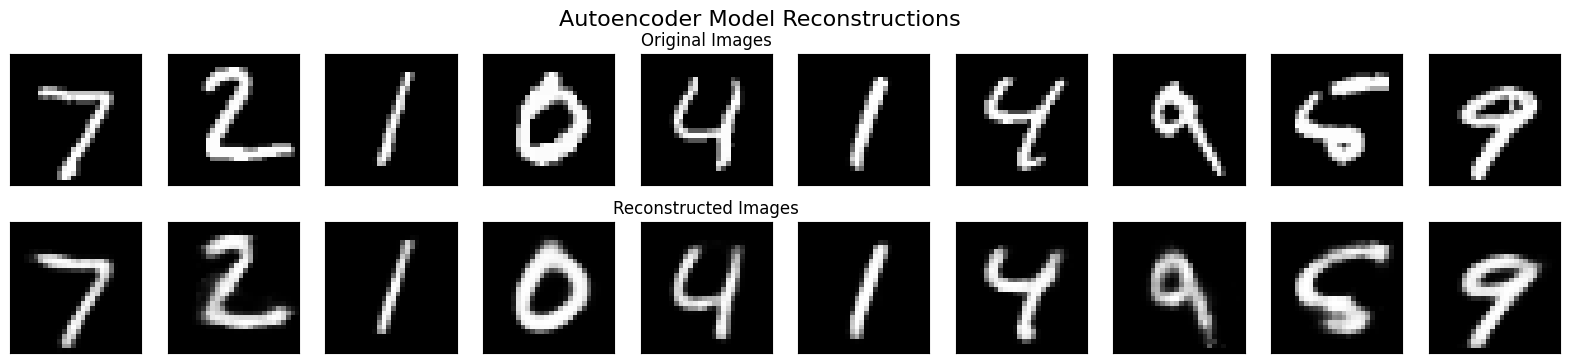

In [9]:
model_ae.eval()
images, _ = next(iter(test_loader))
images = images.to(device)
with torch.no_grad(): reconstructions = model_ae(images)
images, reconstructions = images.cpu(), reconstructions.cpu()
plt.figure(figsize=(20, 4));
for i in range(10):
    ax = plt.subplot(2, 10, i + 1); plt.imshow(images[i].squeeze() * 0.5 + 0.5, cmap='gray'); ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    if i == 4: ax.set_title("Original Images")
    ax = plt.subplot(2, 10, i + 1 + 10); plt.imshow(reconstructions[i].squeeze() * 0.5 + 0.5, cmap='gray'); ax.get_xaxis().set_visible(False); ax.get_yaxis().set_visible(False)
    if i == 4: ax.set_title("Reconstructed Images")
plt.suptitle("Autoencoder Model Reconstructions", fontsize=16)
plt.show()

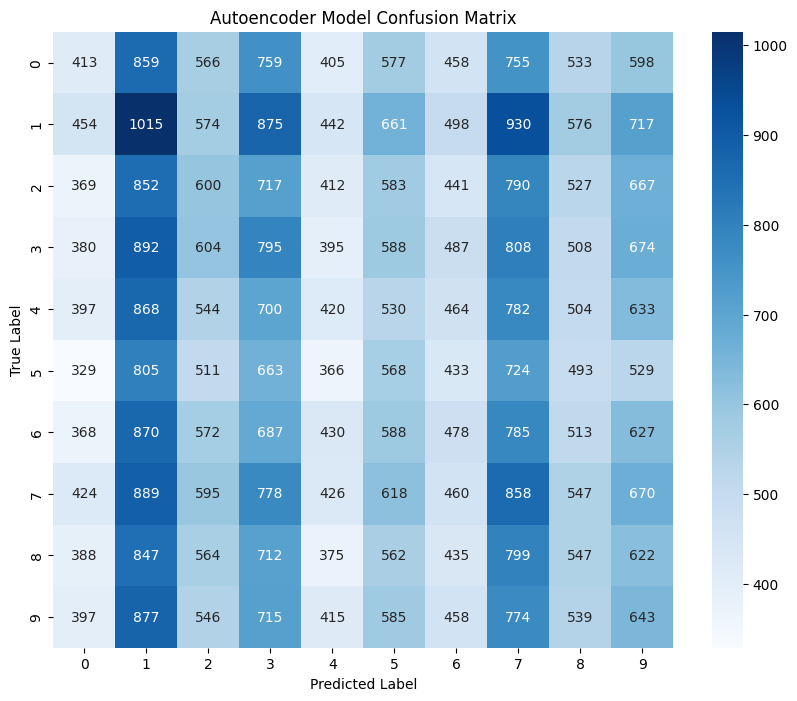

In [10]:
contingency = contingency_matrix(true_labels_full, predicted_labels)
row_ind, col_ind = linear_sum_assignment(-contingency)
remapped_labels = np.zeros_like(predicted_labels)
for i in range(10): remapped_labels[predicted_labels == col_ind[i]] = row_ind[i]
cm = confusion_matrix(true_labels_full, remapped_labels)
plt.figure(figsize=(10, 8)); sns.heatmap(cm, annot=True, fmt='d', cmap='Blues');
plt.title('Autoencoder Model Confusion Matrix'); plt.ylabel('True Label'); plt.xlabel('Predicted Label');
plt.show()

/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


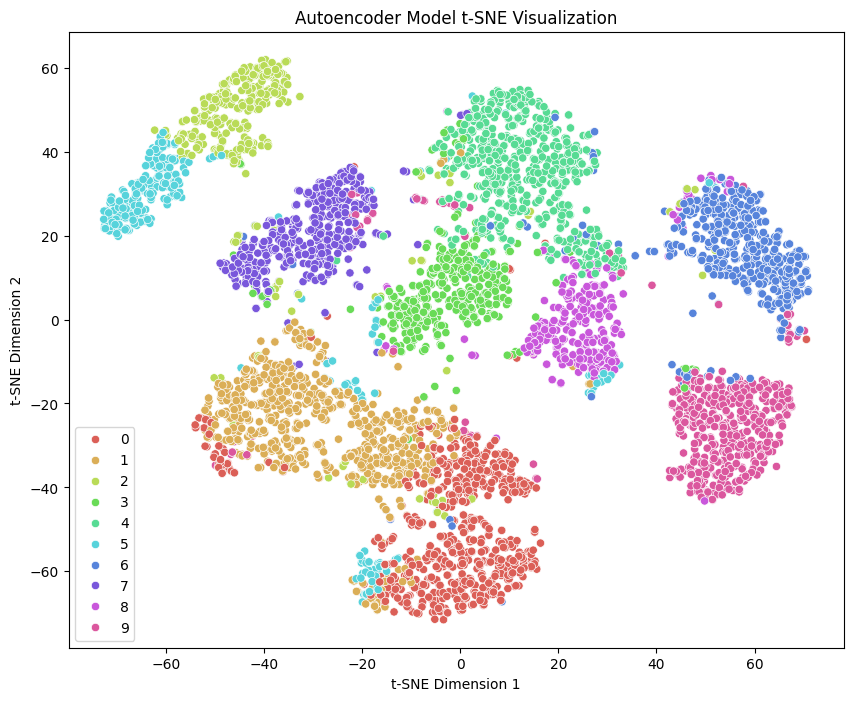

In [11]:
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(sample_vectors)
plt.figure(figsize=(10, 8)); sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1], hue=sample_labels, palette=sns.color_palette("hls", 10), legend="full");
plt.title('Autoencoder Model t-SNE Visualization'); plt.xlabel('t-SNE Dimension 1'); plt.ylabel('t-SNE Dimension 2');
plt.show()